# CRAWL STOCK API

## Nguồn dữ liệu: DStock, FireAnt, VietStock Finance

## Phần 1: Quy Trình Khoa học Dữ liệu

### 1. Chuẩn bị dữ liệu

Import các thư viện cần thiết cho việc thu thập dữ liệu.

In [1]:
import requests
import pandas as pd

Lấy thông tin các công ty đã từng được đưa lên sàn chứng khoán Việt Nam

In [2]:
def get_stock_list():
    VNDIRECT_API = 'https://finfo-api.vndirect.com.vn/v4/stocks'
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36',
        'Content-Type': 'application/json',
    }
    
    params = {
        "q": "type:stock,ifc~floor:HOSE,HNX,UPCOM",
        "size": "9999"
    }
    
    response = requests.get(url = VNDIRECT_API, params = params, headers = headers)
    
    if response.status_code == 200:
        field_to_get = ["code", "type", "status", "companyName", "listedDate", "delistedDate"]
        df = pd.DataFrame(response.json()["data"])
        df = df[field_to_get]
        return pd.DataFrame(df)
        
    return []

In [3]:
stock_data = get_stock_list()
stock_data.head()

,code,type,status,companyName,listedDate,delistedDate
0,ENF,IFC,delisted,Quỹ Đầu tư Năng động Eastspring Investments Vi...,2001-01-01,2001-01-01
1,VESAF,IFC,listed,Công ty Cổ phần Quản lý Quỹ VinaCapital,2020-07-21,NaN
2,MAFPF1,IFC,delisted,Quỹ đầu tư tăng trưởng Manulife,2007-12-28,2014-08-20
3,VEOF,IFC,listed,Công ty Cổ phần Quản lý Quỹ VinaCapital,2020-07-21,NaN
4,VFMVF1,IFC,delisted,Quỹ Đầu Tư Chứng Khoán Việt Nam,2004-11-08,2013-09-24


Data clean up

In [4]:
import re

def cleanRoman(text):
    pattern = r'\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?'
    return re.sub(pattern, '', text)

def cleanText(text):
    pattern = r'[^A-Za-z]+'
    return re.sub(pattern, '', text)

def cleanBullet(text):
    pattern = '\w[.)]\s*'
    return re.sub(pattern, '', text)

def removeVietNameAccent(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

def removeSpace(text):
    pattern = r'\s*'
    return re.sub(pattern, '', text)

Lấy các chỉ số báo cáo tài chính

In [20]:
import datetime

def get_balance_sheet(symbol = "VNM", fromYear = 2021, toYear = 2022):
    companyBalanceSheet = []
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36',
    }
    fireant_bearer_token = "eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsIng1dCI6IkdYdExONzViZlZQakdvNERWdjV4QkRITHpnSSIsImtpZCI6IkdYdExONzViZlZQakdvNERWdjV4QkRITHpnSSJ9.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmZpcmVhbnQudm4iLCJhdWQiOiJodHRwczovL2FjY291bnRzLmZpcmVhbnQudm4vcmVzb3VyY2VzIiwiZXhwIjoxOTM5NDc0NDY3LCJuYmYiOjE2Mzk0NzQ0NjcsImNsaWVudF9pZCI6ImZpcmVhbnQudHJhZGVzdGF0aW9uIiwic2NvcGUiOlsib3BlbmlkIiwicHJvZmlsZSIsInJvbGVzIiwiZW1haWwiLCJhY2NvdW50cy1yZWFkIiwiYWNjb3VudHMtd3JpdGUiLCJvcmRlcnMtcmVhZCIsIm9yZGVycy13cml0ZSIsImNvbXBhbmllcy1yZWFkIiwiaW5kaXZpZHVhbHMtcmVhZCIsImZpbmFuY2UtcmVhZCIsInBvc3RzLXdyaXRlIiwicG9zdHMtcmVhZCIsInN5bWJvbHMtcmVhZCIsInVzZXItZGF0YS1yZWFkIiwidXNlci1kYXRhLXdyaXRlIiwidXNlcnMtcmVhZCIsInNlYXJjaCIsImFjYWRlbXktcmVhZCIsImFjYWRlbXktd3JpdGUiLCJibG9nLXJlYWQiLCJpbnZlc3RvcGVkaWEtcmVhZCJdLCJzdWIiOiJkM2UxY2I4MC0xMDc0LTRhMjItYWY4Ny0yNjlhOGM3Mzc2NmMiLCJhdXRoX3RpbWUiOjE2Mzk0NzQ0NjcsImlkcCI6Ikdvb2dsZSIsIm5hbWUiOiJtaW5odHJpLm1pbmh6enh6eEBnbWFpbC5jb20iLCJzZWN1cml0eV9zdGFtcCI6ImIzNDM3MmFkLTgxZjktNGUyYy04NTc4LTBmYWE3NmIxYmMzOSIsInByZWZlcnJlZF91c2VybmFtZSI6Im1pbmh0cmkubWluaHp6eHp4QGdtYWlsLmNvbSIsInVzZXJuYW1lIjoibWluaHRyaS5taW5oenp4enhAZ21haWwuY29tIiwiZnVsbF9uYW1lIjoiTWluaCBUcmkgTmd1eWVuIiwiZW1haWwiOiJtaW5odHJpLm1pbmh6enh6eEBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6InRydWUiLCJqdGkiOiIzY2FjMTQwZGIxMTRkNGMwOWI2MWJjNTA1NmQ0MDg0OCIsImFtciI6WyJleHRlcm5hbCJdfQ.X9deVcDttd06BxdZC7uOBXeObi3qOYqIsWK190UXRBSbVw-03W4KlsQ5PwKyoAc5beog9zYTtZzoE63cnbJ4o14aq4ljsM4bcFEfP2wLl3taVjuKbJOKaFMLiUFyQGiPc5_iE7b-7Z3cVWyEWtDl9xeqg57vVrBLXvcyzquWTFVKgaumR7PA3EwM5UHQWL8f2nx_zwAW06Y-x6soQItu8byN4Brm6VZK6YawUikZqsNehRxHmd_Q52rd4WJ5cTnLUHSlHNoKzEVOobfvOStE2bkoEceBuwgnjEIgqvFsdEX26lvi7ytkkUad9_Mm4LIs_-MxAnsoop3K0IFMzgq-IQ"
    headers.update({'Authorization': f"Bearer {fireant_bearer_token}"})
    
    FIREANT_API = f"https://restv2.fireant.vn/symbols/{symbol}/full-financial-reports?"
    
    field_to_get = [
        { 'tongcongtaisan': 'totalAssets'},
        { 'taisancodinhhuuhinh': 'tangibleAssets'},
        { 'taisancodinhvohinh': 'intangibleAssets'},
        { 'doanhthuthuan': 'netRevenue'},
        { 'loinhuantruocthue': 'profitBeforeTaxes'},
        { 'loinhuansauthuecuacodongcuacongtyme': 'profitAfterTaxes'},
        { 'tonghangtonkho': 'inventory'},
        { 'nophaitra': 'liabilities'},
        { 'tienvatuongduongtiencuoiky': 'cashAndCashEquivalents'},
        { 'vonchusohuu': 'equity'},
        { 'nonganhan': 'shorttermLiabilities'},
        { 'nodaihan': 'longtermLiabilities'},
        { 'giavonhangban': 'costPrice'},
        { 'khauhaotscd': 'fixedAssetsDepreciation'},
        { 'trongdochiphilaivay': 'lendingCost'},
        { 'vayvanothuetaichinhnganhan': 'shorttermBorrowingsFinancialLeases'},
        { 'vayvanothuetaichinhdaihan': 'longtermBorrowingsFinancialLeases'},
    ]
    
    for year in range(fromYear, toYear+1):
        for quarter in range(1, 4+1):
            if datetime.datetime(year, quarter*3, 1) > datetime.datetime.now():
                continue
            
            print(f"Getting data for {symbol} - {year} - {quarter}")
                  
            quarterBalanceSheet = {}
                                    
            for field in field_to_get:
                quarterBalanceSheet.update({list(field.values())[0] : 0})
             
            # 1  : "candoiketoan"
            # 2  : "ketquakinhdoanh"
            # 3  : "luuchuyentientett"
            # 4  : "luuchuyentientegt"
            for statementType in range(1, 5):                    
                params = {
                    "type": statementType, 
                    "year": year,
                    "quarter": quarter,
                    "limit": 1,
                }
                
                fireant_response = requests.get(FIREANT_API, headers=headers, params=params).json()
                                
                try:
                    if (fireant_response != None):
                        for field_respone in fireant_response:
                            if ('name' not in field_respone): continue
                            
                            field_name =  removeSpace(cleanText(removeVietNameAccent(cleanBullet(cleanRoman(field_respone['name']))))).lower()
                            field_value = field_respone['values'][0]['value'] or 0
                            
                            for field in field_to_get:
                                if field_name in field: quarterBalanceSheet.update({field[field_name]: str(field_value)})
                    
                    quarterBalanceSheet.update({f"year": year})
                    quarterBalanceSheet.update({f"quarter": quarter})
                    
                except:
                    print(f"{symbol} - {year} - {quarter} - {statementType} - {fireant_response}")
                    raise
                
            companyBalanceSheet.append(quarterBalanceSheet)
    return companyBalanceSheet

Lấy chỉ số báo cáo tài chính của công ty

In [6]:
print(get_balance_sheet())

Getting data for VNM - 2021 - 1
Getting data for VNM - 2021 - 2
Getting data for VNM - 2021 - 3
Getting data for VNM - 2021 - 4
Getting data for VNM - 2022 - 1
Getting data for VNM - 2022 - 2
Getting data for VNM - 2022 - 3
Getting data for VNM - 2022 - 4
[{'totalAssets': '51051210880651.0', 'tangibleAssets': '12450177265747.0', 'intangibleAssets': '1131385809125.0', 'netRevenue': '13190270122852.0', 'profitBeforeTaxes': '3153910222805.0', 'profitAfterTaxes': '2575916578653.0', 'inventory': '6465943104329.0', 'liabilities': '17087270259224.0', 'cashAndCashEquivalents': '1197956795582.0', 'equity': '33963940621427.0', 'shorttermLiabilities': '16532816332955.0', 'longtermLiabilities': '554453926269.0', 'costPrice': '7435389686438.0', 'fixedAssetsDepreciation': '561074222639.0', 'lendingCost': '12905990201.0', 'shorttermBorrowingsFinancialLeases': '9247097278828.0', 'longtermBorrowingsFinancialLeases': '162103516784.0', 'year': 2021, 'quarter': 1}, {'totalAssets': '53046669029192.0', 'tan

In [6]:
mask_active_stock_comapny = (stock_data['status'] == 'listed') & (stock_data['type'] == 'STOCK')
active_company = stock_data[mask_active_stock_comapny]
active_company

,code,type,status,companyName,listedDate,delistedDate
14,THT,STOCK,listed,Công ty Cổ phần than Hà Tu – Vinacomin,2008-10-24,NaN
15,PJC,STOCK,listed,Công ty Cổ phần Thương mại và Vận tải Petrolim...,2006-12-25,NaN
16,SD5,STOCK,listed,Công ty Cổ phần Sông Đà 5,2006-12-27,NaN
17,SDT,STOCK,listed,Công ty Cổ phần Sông Đà 10,2006-12-14,NaN
19,PVG,STOCK,listed,CÔNG TY CỔ PHẦN KINH DOANH LPG VIỆT NAM,2009-01-07,NaN
...,...,...,...,...,...,...
1889,TDG,STOCK,listed,Công ty Cổ phần Đầu tư TDG GLOBAL,2017-06-15,NaN
1890,SMB,STOCK,listed,Công ty Cổ phần Bia Sài Gòn - Miền Trung,2018-08-03,NaN
1891,AMD,STOCK,listed,Công ty cổ phần đầu tư và khoáng sản FLC Stone,2015-06-16,NaN
1892,CTF,STOCK,listed,Công ty Cổ phần City Auto,2017-05-30,NaN


In [ ]:
# get balance sheet for all active company and save to csv file
'''
for index, row in active_company.iterrows():
    symbol = row['code']
    company_balance_sheet = get_balance_sheet(symbol)
    
    pd.DataFrame(company_balance_sheet).to_csv(f"./dataset/{symbol}.csv", index=False)
'''

In [7]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   code          1895 non-null   object
 1   type          1895 non-null   object
 2   status        1895 non-null   object
 3   companyName   1895 non-null   object
 4   listedDate    1895 non-null   object
 5   delistedDate  293 non-null    object
dtypes: object(6)
memory usage: 89.0+ KB


In [8]:
stock_data['listedDate'] = pd.to_datetime(stock_data['listedDate'], format='%Y-%m-%d')

In [13]:
active_company_from_2015 = stock_data[(stock_data['listedDate'].dt.year < 2016) & (stock_data['status'] == 'listed') & (stock_data['type'] == 'STOCK')]
active_company_from_2015

,code,type,status,companyName,listedDate,delistedDate
14,THT,STOCK,listed,Công ty Cổ phần than Hà Tu – Vinacomin,2008-10-24,NaN
15,PJC,STOCK,listed,Công ty Cổ phần Thương mại và Vận tải Petrolim...,2006-12-25,NaN
16,SD5,STOCK,listed,Công ty Cổ phần Sông Đà 5,2006-12-27,NaN
17,SDT,STOCK,listed,Công ty Cổ phần Sông Đà 10,2006-12-14,NaN
19,PVG,STOCK,listed,CÔNG TY CỔ PHẦN KINH DOANH LPG VIỆT NAM,2009-01-07,NaN
...,...,...,...,...,...,...
1883,VSC,STOCK,listed,Công ty Cổ phần Container Việt Nam,2008-01-09,NaN
1886,SGT,STOCK,listed,Công ty Cổ phần Công nghệ Viễn thông Sài Gòn,2008-01-18,NaN
1887,VSI,STOCK,listed,Công ty Cổ phần đầu tư và xây dựng cấp thoát nước,2010-12-24,NaN
1891,AMD,STOCK,listed,Công ty cổ phần đầu tư và khoáng sản FLC Stone,2015-06-16,NaN


In [15]:
active_company_from_2015 = active_company_from_2015.sample(100)

In [21]:
for index, row in active_company_from_2015.iterrows():
    symbol = row['code']
    company_balance_sheet = get_balance_sheet(symbol,2017,2022)
    
    pd.DataFrame(company_balance_sheet).to_csv(f"./dataset_from2015/{symbol}.csv", index=False)

Getting data for TKU - 2017 - 1
Getting data for TKU - 2017 - 2
Getting data for TKU - 2017 - 3
Getting data for TKU - 2017 - 4
Getting data for TKU - 2018 - 1
Getting data for TKU - 2018 - 2
Getting data for TKU - 2018 - 3
Getting data for TKU - 2018 - 4
Getting data for TKU - 2019 - 1
Getting data for TKU - 2019 - 2
Getting data for TKU - 2019 - 3
Getting data for TKU - 2019 - 4
Getting data for TKU - 2020 - 1
Getting data for TKU - 2020 - 2
Getting data for TKU - 2020 - 3
Getting data for TKU - 2020 - 4
Getting data for TKU - 2021 - 1
Getting data for TKU - 2021 - 2
Getting data for TKU - 2021 - 3
Getting data for TKU - 2021 - 4
Getting data for TKU - 2022 - 1
Getting data for TKU - 2022 - 2
Getting data for TKU - 2022 - 3
Getting data for TKU - 2022 - 4
Getting data for TV4 - 2017 - 1
Getting data for TV4 - 2017 - 2
Getting data for TV4 - 2017 - 3
Getting data for TV4 - 2017 - 4
Getting data for TV4 - 2018 - 1
Getting data for TV4 - 2018 - 2
Getting data for TV4 - 2018 - 3
Getting 

ConnectTimeout: HTTPSConnectionPool(host='restv2.fireant.vn', port=443): Max retries exceeded with url: /symbols/VDN/full-financial-reports?type=4&year=2020&quarter=3&limit=1 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001826AB5C3D0>, 'Connection to restv2.fireant.vn timed out. (connect timeout=None)'))

### 2. Khám phá dữ liệu 

#### Đọc dữ liệu từ file csv vào data frame

In [48]:
import glob
import os
from pathlib import Path
import pandas as pd
import matplotlib as plt

In [49]:
#add your folder path
folder_path = './dataset'

file_type = 'csv'
seperator =','

files = Path(folder_path).glob('*.csv')

dfs = list()
for f in files:
    data = pd.read_csv(f)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f.stem
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [50]:
df

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
0,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,1,A32
1,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,2,A32
2,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,3,A32
3,5.281309e+11,1.139765e+11,2.770250e+08,0.0,0.0,0.0,1.922260e+11,2.897457e+11,0.0,2.380572e+11,2.897457e+11,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2021,4,A32
4,5.281309e+11,1.139765e+11,2.770250e+08,0.0,0.0,0.0,1.922260e+11,2.897457e+11,0.0,2.380572e+11,2.897457e+11,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2022,1,A32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12088,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2021,4,YTC
12089,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,1,YTC
12090,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,2,YTC
12091,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,3,YTC


#### Dữ liệu gồm có bao nhiêu dòng và cột?

In [12]:
num_rows = len(df.axes[0])
num_cols = len(df.axes[1])
print('Row: ',num_rows)
print("Cols: ",num_cols)

Row:  12093
Cols:  20


#### Mỗi dòng có ý nghĩa gì?

 - Một dòng cho biết báo cáo tài chính của 1 công ty trong 1 quý

#### Dữ liệu có các dòng bị lặp không?

In [13]:
have_duplicated_rows = False
for i in df.duplicated().items():
    if(i[1] == True):
        have_duplicated_rows = True

In [14]:
assert have_duplicated_rows == False

- Như vậy không có dòng nào bị lặp

#### Mỗi cột có ý nghĩa gì?

- totalAssets: tổng giá trị tài sản 
- tangibleAssets: tài sản cố định hữu hình
- intangibleAsets: tài sản cố định vô hình
- netRevenue: doanh thu thuần
- profitBeforeTaxes: lợi nhuận trước thuế
- profitAfterTaxes: lợi nhuận sau thuế của cổ đông công ty mẹ
- inventory: tổng hàng tồn kho
- liabilities: nợ phải trả
- cashAndCashEquivalents: tiền mặt và các khoảng tương đương tiền
- equity: vốn chủ sở hữu
- shorttermLiabilities: nợ ngắn hạn
- longtermLiabilities: nợ dài hạn
- costPrice: giá vốn hàng bán
- fixedAssetsDepreciation: khấu hao tài sản cố định
- lendingCost: chi phí lãi vay
- shorttermBorrowingsFinancialLeases: vay nợ tài chính ngắn hạn
- longtermBorrowingsFinancialLeases: vay nợ tài chính dài hạn
- year: năm tài chính
- quarter: quý
- file: mã code của công ty

#### Mỗi cột hiện đang có kiểu dữ liệu gì?

In [15]:
col_dtypes = df.dtypes
col_dtypes

totalAssets                           float64
tangibleAssets                        float64
intangibleAssets                      float64
netRevenue                            float64
profitBeforeTaxes                     float64
profitAfterTaxes                      float64
inventory                             float64
liabilities                           float64
cashAndCashEquivalents                float64
equity                                float64
shorttermLiabilities                  float64
longtermLiabilities                   float64
costPrice                             float64
fixedAssetsDepreciation               float64
lendingCost                           float64
shorttermBorrowingsFinancialLeases    float64
longtermBorrowingsFinancialLeases     float64
year                                    int64
quarter                                 int64
file                                   object
dtype: object

### Với mỗi cột có kiểu dữ liệu dạng numeric, các giá trị được phân bố như thế nào?

In [16]:
nume_col_df = df.drop(columns='file')
missing_ratio = (nume_col_df.isnull().sum() * 100 / len(nume_col_df))
min = nume_col_df.min()
max = nume_col_df.max()
row_name = ['missing_ratio','min','max']
nume_col_profiles_df = pd.DataFrame([missing_ratio,min,max],index=row_name )
nume_col_profiles_df


,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter
missing_ratio,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
min,0.000000e+00,0.000000e+00,-5.030851e+07,-3.013541e+10,-6.368911e+12,-5.964033e+12,0.000000e+00,-3.785290e+08,-5.037415e+10,-7.510581e+12,-3.785290e+08,-1.406817e+10,-3.163224e+10,-1.416283e+12,-7.143791e+11,-5.000000e+06,-5.000000e+08,2021.0,1.0
max,2.048953e+15,1.067823e+14,2.367280e+13,8.498254e+13,1.894868e+13,1.449384e+13,1.296364e+14,4.183456e+14,2.903638e+14,1.642971e+14,2.863270e+14,1.583577e+14,8.252628e+13,6.325887e+12,3.036936e+12,6.281971e+13,1.109495e+14,2022.0,4.0


### Cột có kiểu dữ liệu dạng không phải numeric, các giá trị được phân bố như thế nào?

In [17]:
object_col_df = df[["file"]] # tên file là tên của doanh nghiệp
missing_ratio = object_col_df.isnull().sum() * 100 / len(object_col_df)
num_diff_vals = object_col_df.nunique()
diff_vals = [object_col_df[col_name].dropna().unique() for col_name in object_col_df.columns]
r_name = ["missing_ratio", "num_diff_vals", "diff_vals"]

object_col_profiles_df = pd.DataFrame([missing_ratio,num_diff_vals,pd.Series(diff_vals,index=["file"])],index=r_name)
object_col_profiles_df


,file
missing_ratio,0.0
num_diff_vals,1602
diff_vals,"[A32, AAA, AAM, AAS, AAT, AAV, ABB, ABC, ABI, ..."


## 3. Trả lời câu hỏi

#### Câu 1: Công ty nào có tỷ lệ tăng trưởng tốt nhất trong năm 2022 ? 

In [18]:
df_netRenevue = df[['netRevenue','quarter','year','file']]
df_netRenevue

,netRevenue,quarter,year,file
0,0.0,1,2021,A32
1,0.0,2,2021,A32
2,0.0,3,2021,A32
3,0.0,4,2021,A32
4,0.0,1,2022,A32
...,...,...,...,...
12088,0.0,4,2021,YTC
12089,0.0,1,2022,YTC
12090,0.0,2,2022,YTC
12091,0.0,3,2022,YTC


Chỉ giữ lại các quý cuối của năm

In [19]:
i = df_netRenevue[(df_netRenevue['quarter'] != 4)].index
df_netRenevue = df_netRenevue.drop(i)

Tính tỷ lệ tăng trưởng của năm 2022 so với năm 2021

In [20]:
df_netRenevue['Growth Rate']=df_netRenevue.groupby('file')['netRevenue'].pct_change()
df_netRenevue

,netRevenue,quarter,year,file,Growth Rate
3,0.000000e+00,4,2021,A32,NaN
7,0.000000e+00,4,2022,A32,NaN
11,4.198836e+12,4,2021,AAA,NaN
15,3.280335e+12,4,2022,AAA,-0.218751
19,6.136024e+10,4,2021,AAM,NaN
...,...,...,...,...,...
12076,8.244484e+10,4,2022,YBM,-0.407920
12080,2.475393e+11,4,2021,YEG,NaN
12084,7.080504e+10,4,2022,YEG,-0.713964
12088,0.000000e+00,4,2021,YTC,NaN


Xoá các dòng có tỷ lệ tăng trưởng là NaN

In [21]:
df_netRenevue_gr = df_netRenevue.dropna(subset='Growth Rate')
df_netRenevue_gr

,netRevenue,quarter,year,file,Growth Rate
15,3.280335e+12,4,2022,AAA,-0.218751
23,4.636050e+10,4,2022,AAM,-0.244454
38,1.183720e+11,4,2022,AAT,0.743902
60,3.519471e+11,4,2022,ABC,-0.708752
76,2.774684e+10,4,2022,ABR,0.199428
...,...,...,...,...,...
12045,5.305793e+10,4,2022,XMD,0.000000
12053,1.702518e+10,4,2022,XMP,0.473288
12068,1.188447e+11,4,2022,YBC,0.000000
12076,8.244484e+10,4,2022,YBM,-0.407920


Lấy ra công ty có tỷ lệ tăng trưởng cao nhất

In [22]:
biggest_growth_rate = df_netRenevue_gr.loc[df_netRenevue_gr['Growth Rate'].idxmax()] 
biggest_growth_rate

netRevenue     59059470035.0
quarter                    4
year                    2022
file                     BMJ
Growth Rate              inf
Name: 912, dtype: object

In [23]:
stock_data.loc[stock_data['code'] == biggest_growth_rate['file']]

,code,type,status,companyName,listedDate,delistedDate
1447,BMJ,STOCK,listed,Công ty cổ phần khoáng sản Miền Đông AHP,2009-12-22,NaN


- Vậy công ty có tỷ lệ tăng trưởng tốt nhất trong năm 2022 là Công ty cổ phần khoáng sản Miền Đông AHP

#

#### 2. Trong 2 năm thu thập, các công ty nào đã bị deslist khỏi sàn chứng khoán, và xếp hạng tăng trưởng doanh thu của họ so với các công ty như thế nào?

Danh sách các công ty đã bị delist

In [24]:
mask_inactive_stock_comapny = (stock_data['status'] == 'delisted') & (stock_data['type'] == 'STOCK') 
inactive_company = stock_data[mask_inactive_stock_comapny]
inactive_company

,code,type,status,companyName,listedDate,delistedDate
18,YSC,STOCK,delisted,Công ty Cổ phần HAPACO Yên Sơn,2006-12-29,2011-08-23
30,HHL,STOCK,delisted,Công ty Cổ phần Hồng Hà Long An,2010-01-08,2014-05-07
35,KBT,STOCK,delisted,Công ty Cổ phần Gạch ngói Kiên Giang,2010-07-29,2013-11-28
43,KMF,STOCK,delisted,Công ty Cổ phần Mirae Fiber,2007-12-14,2009-12-22
45,NVC,STOCK,delisted,Công ty Cổ phần Nam Vang,2008-01-24,2014-05-23
...,...,...,...,...,...,...
1851,TIC,STOCK,delisted,Công ty Cổ phần Đầu tư điện Tây Nguyên,2009-10-12,2017-10-11
1868,DCC,STOCK,delisted,Công ty Cổ phần Xây dựng công nghiệp DESCON,2007-12-12,2011-12-15
1870,ALP,STOCK,delisted,Công ty Cổ phần Đầu tư Alphanam,2007-12-18,2014-12-30
1878,SBC,STOCK,delisted,Công ty Cổ phần Vận tải và Giao nhận Bia Sài Gòn,2010-06-02,2015-02-11


In [25]:
inactive_company['delistedDate'] = pd.to_datetime(inactive_company['delistedDate'], format='%Y-%m-%d')

C:\Users\Tin\AppData\Local\Temp\ipykernel_21404\1218502265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive_company['delistedDate'] = pd.to_datetime(inactive_company['delistedDate'], format='%Y-%m-%d')


Danh sách các công ty bị delist trong 2 năm 2021,2022

In [26]:
inactive_company_21_22 = inactive_company[(inactive_company['delistedDate'].dt.year == 2022) | (inactive_company['delistedDate'].dt.year == 2021)]
inactive_company_21_22

,code,type,status,companyName,listedDate,delistedDate
66,EBA,STOCK,delisted,Công ty Cổ phần Điện Bắc Nà,2019-12-31,2021-08-31
285,HBE,STOCK,delisted,Công ty Cổ phần Sách-Thiết bị trường học Hà Tĩnh,2008-02-22,2021-08-09
412,CT5,STOCK,delisted,CÔNG TY CỔ PHẦN 319.5,2020-01-16,2022-04-01
416,BXT,STOCK,delisted,Công ty Cổ phần Bến xe tàu Hậu Giang,2019-06-10,2022-04-01
432,FDG,STOCK,delisted,Công ty Cổ phần DOCIMEXCO,2016-08-19,2022-07-11
...,...,...,...,...,...,...
1528,CEE,STOCK,delisted,Công ty Cổ phần Xây dựng Hạ tầng CII,2017-05-15,2022-07-21
1529,PME,STOCK,delisted,Công ty Cổ phần Pymepharco,2017-11-08,2021-12-03
1530,GTN,STOCK,delisted,Công ty cổ phần GTNFOODS,2014-10-03,2022-03-07
1739,TAC,STOCK,delisted,Công ty Cổ phần Dầu thực vật Tường An,2006-12-26,2022-05-19


Lấy báo cáo tài chính của các công ty này

In [27]:
'''
for index, row in inactive_company_21_22.iterrows():
    symbol = row['code']
    company_balance_sheet = get_balance_sheet(symbol)
    
    pd.DataFrame(company_balance_sheet).to_csv(f"./delisted_dataset/{symbol}.csv", index=False)
'''

'\nfor index, row in inactive_company_21_22.iterrows():\n    symbol = row[\'code\']\n    company_balance_sheet = get_balance_sheet(symbol)\n    \n    pd.DataFrame(company_balance_sheet).to_csv(f"./delisted_dataset/{symbol}.csv", index=False)\n'

In [28]:
folder_path = './delisted_dataset'

file_type = 'csv'
seperator =','

files = Path(folder_path).glob('*.csv')

dfs = list()
for f in files:
    data = pd.read_csv(f)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f.stem
    dfs.append(data)

df_2 = pd.concat(dfs, ignore_index=True)


In [29]:
df_2

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,AC4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,AC4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,3,AC4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,4,AC4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1,AC4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,4,YRC
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1,YRC
1013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,2,YRC
1014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,3,YRC


Đối với các công ty đã bị delist khỏi sàn thì báo cáo tài chính cũng không có thông tin gì. Ta có thể nhận thấy các công ty này hoạt động không minh bạch nên mới bị delist.

#

#### 3. Top 10 công ty giàu nhất (có tổng giá trị tài sản lớn nhất và nợ phải trả nhỏ nhất)

In [30]:
df_sorted = df.sort_values(by=['totalAssets', 'liabilities'], ascending=[False,True])
df_sorted

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
783,2.048953e+15,5.800792e+12,4.331045e+12,0.0,0.0,0.0,0.0,0.0,2.550333e+14,9.625724e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,3,BID
784,2.048953e+15,5.800792e+12,4.331045e+12,0.0,0.0,0.0,0.0,0.0,2.550333e+14,9.625724e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,4,BID
782,1.979293e+15,5.953329e+12,4.306598e+12,0.0,0.0,0.0,0.0,0.0,2.223396e+14,9.093993e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,2,BID
781,1.847704e+15,6.156731e+12,4.352564e+12,0.0,0.0,0.0,0.0,0.0,1.802869e+14,8.663130e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1,BID
780,1.761939e+15,6.338007e+12,4.403150e+12,0.0,0.0,0.0,0.0,0.0,1.653456e+14,8.318258e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,4,BID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7709,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,PTN
7710,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,3,PTN
11913,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,VVS
11914,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,VVS


In [31]:
i = df_sorted[(df_sorted['year'] == 2021)].index
df_sorted = df_sorted.drop(i)
i = df_sorted[(df_sorted['quarter'] != 4)].index
df_sorted = df_sorted.drop(i)
df_sorted

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
784,2.048953e+15,5.800792e+12,4.331045e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2.550333e+14,9.625724e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,BID
2061,1.750790e+15,5.847374e+12,4.160255e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2.071284e+14,1.053783e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,CTG
10823,1.649664e+15,5.060100e+12,2.760412e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2.903638e+14,1.282873e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,VCB
9533,6.713535e+14,3.527356e+12,3.754525e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,8.356209e+13,1.088668e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,TCB
5809,6.568042e+14,3.008546e+12,1.403752e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,4.670320e+13,7.252174e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,MBB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,1.280781e+10,1.758893e+09,0.000000e+00,3.815750e+11,0.0,0.0,0.000000e+00,2.840963e+11,0.000000e+00,-2.712885e+11,2.775730e+11,6.523251e+09,3.708530e+11,0.0,0.0,1.856317e+11,6.523251e+09,2022,4,VTI
8048,1.271185e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,2.739546e+06,1.952708e+09,0.000000e+00,1.075914e+10,1.952708e+09,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,QNT
1635,1.164803e+10,1.733955e+08,0.000000e+00,9.718350e+08,0.0,82773425.0,1.018482e+09,1.599325e+09,1.509815e+09,1.004870e+10,1.599325e+09,0.000000e+00,5.121571e+08,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,CID
6863,1.013359e+10,3.750005e+06,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,5.438969e+09,0.000000e+00,4.694620e+09,5.438969e+09,0.000000e+00,0.000000e+00,0.0,0.0,9.254404e+07,0.000000e+00,2022,4,ONW


In [32]:
top10_df = df_sorted.head(10)
top10_df

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
784,2.048953e+15,5.800792e+12,4.331045e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.550333e+14,9.625724e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,BID
2061,1.750790e+15,5.847374e+12,4.160255e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.071284e+14,1.053783e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,CTG
10823,1.649664e+15,5.060100e+12,2.760412e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.903638e+14,1.282873e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,VCB
9533,6.713535e+14,3.527356e+12,3.754525e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.356209e+13,1.088668e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,TCB
5809,6.568042e+14,3.008546e+12,1.403752e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.670320e+13,7.252174e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,MBB
11575,5.959019e+14,1.188276e+12,6.556100e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.889722e+13,9.457916e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,VPB
9246,5.641929e+14,4.574837e+12,3.391696e+12,0.000000e+00,2.143140e+11,0.000000e+00,0.000000e+00,0.000000e+00,1.456036e+13,3.694025e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,STB
100,5.611137e+14,2.665262e+12,1.068585e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.289407e+13,5.573473e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,ACB
11213,5.555710e+14,9.741168e+13,1.718282e+13,2.874236e+13,5.252320e+12,9.467810e+11,8.575057e+13,4.183456e+14,2.644957e+13,1.372254e+14,2.863270e+14,1.320186e+14,2.298405e+13,6.325887e+12,3.036936e+12,6.281971e+13,1.097033e+14,2022,4,VIC
8797,5.285600e+14,4.901200e+11,4.446149e+12,0.000000e+00,8.324712e+10,0.000000e+00,0.000000e+00,0.000000e+00,5.900286e+12,4.229424e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,SHB


In [33]:
top10_df = top10_df.set_index('file')
top10_df

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter
file,,,,,,,,,,,,,,,,,,,
BID,2.048953e+15,5.800792e+12,4.331045e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.550333e+14,9.625724e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
CTG,1.750790e+15,5.847374e+12,4.160255e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.071284e+14,1.053783e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
VCB,1.649664e+15,5.060100e+12,2.760412e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.903638e+14,1.282873e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
TCB,6.713535e+14,3.527356e+12,3.754525e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.356209e+13,1.088668e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
MBB,6.568042e+14,3.008546e+12,1.403752e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.670320e+13,7.252174e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
VPB,5.959019e+14,1.188276e+12,6.556100e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.889722e+13,9.457916e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
STB,5.641929e+14,4.574837e+12,3.391696e+12,0.000000e+00,2.143140e+11,0.000000e+00,0.000000e+00,0.000000e+00,1.456036e+13,3.694025e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
ACB,5.611137e+14,2.665262e+12,1.068585e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.289407e+13,5.573473e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
VIC,5.555710e+14,9.741168e+13,1.718282e+13,2.874236e+13,5.252320e+12,9.467810e+11,8.575057e+13,4.183456e+14,2.644957e+13,1.372254e+14,2.863270e+14,1.320186e+14,2.298405e+13,6.325887e+12,3.036936e+12,6.281971e+13,1.097033e+14,2022,4


<AxesSubplot: xlabel='Tên các công ty', ylabel='Tổng tài sản'>

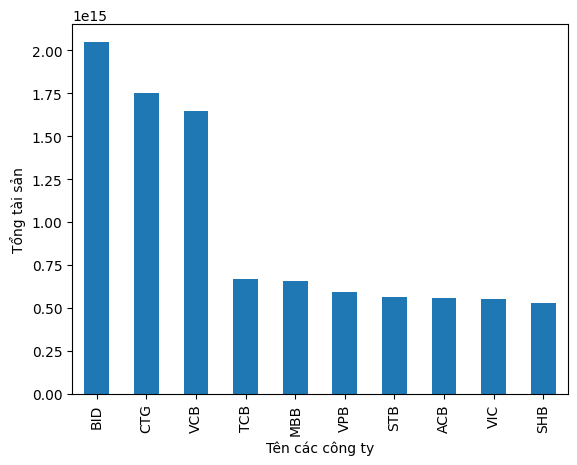

In [34]:
top10_df['totalAssets'].plot.bar(xlabel='Tên các công ty', ylabel='Tổng tài sản')

- Dễ dàng nhận thấy các công ty trên đều là Ngân hàng 

#

#### 4. Độ tăng trưởng qua các mốc thời gian của top 3 công ty lên sàn sớm nhất 
#### (Độ tăng trưởng qua thời gian được tính bằng doanh thu thuần của các quý trong 2 năm 2021, 2022)

In [35]:
active_company['listedDate'] = pd.to_datetime(active_company['listedDate'], format='%Y-%m-%d')
active_company

C:\Users\Tin\AppData\Local\Temp\ipykernel_21404\3484018180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_company['listedDate'] = pd.to_datetime(active_company['listedDate'], format='%Y-%m-%d')


,code,type,status,companyName,listedDate,delistedDate
14,THT,STOCK,listed,Công ty Cổ phần than Hà Tu – Vinacomin,2008-10-24,NaN
15,PJC,STOCK,listed,Công ty Cổ phần Thương mại và Vận tải Petrolim...,2006-12-25,NaN
16,SD5,STOCK,listed,Công ty Cổ phần Sông Đà 5,2006-12-27,NaN
17,SDT,STOCK,listed,Công ty Cổ phần Sông Đà 10,2006-12-14,NaN
19,PVG,STOCK,listed,CÔNG TY CỔ PHẦN KINH DOANH LPG VIỆT NAM,2009-01-07,NaN
...,...,...,...,...,...,...
1889,TDG,STOCK,listed,Công ty Cổ phần Đầu tư TDG GLOBAL,2017-06-15,NaN
1890,SMB,STOCK,listed,Công ty Cổ phần Bia Sài Gòn - Miền Trung,2018-08-03,NaN
1891,AMD,STOCK,listed,Công ty cổ phần đầu tư và khoáng sản FLC Stone,2015-06-16,NaN
1892,CTF,STOCK,listed,Công ty Cổ phần City Auto,2017-05-30,NaN


In [36]:
active_company = active_company.sort_values(by='listedDate')
active_company

,code,type,status,companyName,listedDate,delistedDate
1552,REE,STOCK,listed,Công ty Cổ phần Cơ điện lạnh,2000-07-28,NaN
1553,SAM,STOCK,listed,Công ty Cổ phần SAM HOLDINGS,2000-07-28,NaN
1709,TMS,STOCK,listed,CÔNG TY CỔ PHẦN TRANSIMEX,2000-08-04,NaN
1563,GIL,STOCK,listed,Công ty Cổ phần Sản Xuất Kinh Doanh Xuất Nhập ...,2002-01-02,NaN
1818,GMD,STOCK,listed,Công ty Cổ phần Gemadept,2002-04-22,NaN
...,...,...,...,...,...,...
421,PTN,STOCK,listed,Công ty Cổ phần Phát triển nhà Khánh Hòa,2022-10-14,NaN
1395,MCD,STOCK,listed,Công ty Cổ phần Môi trường và Công trình Đô th...,2022-10-20,NaN
1396,CMM,STOCK,listed,Công ty Cổ phần Camimex,2022-11-08,NaN
1881,NO1,STOCK,listed,Công ty Cổ phần tập đoàn 911,2022-11-28,NaN


In [37]:
top3_df = active_company.head(3)
top3_df

,code,type,status,companyName,listedDate,delistedDate
1552,REE,STOCK,listed,Công ty Cổ phần Cơ điện lạnh,2000-07-28,NaN
1553,SAM,STOCK,listed,Công ty Cổ phần SAM HOLDINGS,2000-07-28,NaN
1709,TMS,STOCK,listed,CÔNG TY CỔ PHẦN TRANSIMEX,2000-08-04,NaN


In [38]:
top3_detail_df = df[df['file'].isin(top3_df['code'])]
top3_detail_df

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
8153,2.081733e+13,2.522436e+12,6.556665e+10,1.182852e+12,5.384919e+11,4.158117e+11,8.337803e+11,8.189844e+12,1.177800e+12,1.262748e+13,3.127228e+12,5.062616e+12,7.465191e+11,8.809503e+10,9.266912e+10,1.234081e+12,4.509644e+12,2021,1,REE
8154,3.037686e+13,1.286556e+13,6.568453e+10,1.636415e+12,5.311780e+11,3.836754e+11,8.983592e+11,1.498786e+13,2.301829e+12,1.538900e+13,4.604048e+12,1.038381e+13,9.727350e+11,2.620154e+11,1.908800e+11,1.284560e+12,9.675112e+12,2021,2,REE
8155,3.092917e+13,1.265620e+13,6.648973e+10,1.092655e+12,2.986038e+11,2.636434e+11,8.503804e+11,1.526464e+13,2.075495e+12,1.566453e+13,3.845289e+12,1.141935e+13,7.431568e+11,2.600372e+11,1.838597e+11,8.534743e+11,1.070164e+13,2021,3,REE
8156,3.182635e+13,1.599180e+13,6.586816e+10,1.897889e+12,1.032663e+12,7.917987e+11,7.988923e+11,1.547035e+13,1.830901e+12,1.635600e+13,4.356127e+12,1.111422e+13,1.035268e+12,2.849346e+11,1.950512e+11,1.323842e+12,1.065012e+13,2021,4,REE
8157,3.240240e+13,1.573405e+13,6.863300e+10,2.045412e+12,1.046810e+12,6.933370e+11,9.102066e+11,1.545680e+13,1.776626e+12,1.694561e+13,4.087803e+12,1.136899e+13,8.950500e+11,3.034679e+11,2.139164e+11,1.237490e+12,1.070160e+13,2022,1,REE
8158,3.250167e+13,1.552025e+13,6.847061e+10,2.022940e+12,8.446056e+11,5.964456e+11,1.019531e+12,1.493134e+13,1.607324e+12,1.757033e+13,3.962627e+12,1.096871e+13,1.127008e+12,3.019725e+11,2.126482e+11,1.345194e+12,1.030315e+13,2022,2,REE
8159,3.304482e+13,1.580641e+13,6.865573e+10,2.233220e+12,9.243501e+11,6.808553e+11,1.254925e+12,1.481449e+13,1.061800e+12,1.823033e+13,3.793038e+12,1.102145e+13,1.315625e+12,3.212181e+11,2.221977e+11,1.170605e+12,1.035020e+13,2022,3,REE
8160,3.304482e+13,1.580641e+13,6.865573e+10,2.233220e+12,9.243501e+11,6.808553e+11,1.254925e+12,1.481449e+13,1.061800e+12,1.823033e+13,3.793038e+12,1.102145e+13,1.315625e+12,3.212181e+11,2.221977e+11,1.170605e+12,1.035020e+13,2022,4,REE
8272,6.144258e+12,7.190847e+11,3.396468e+10,4.433720e+11,0.000000e+00,7.586843e+09,4.033677e+11,1.730913e+12,4.128675e+11,4.413345e+12,1.378422e+12,3.524908e+11,4.123673e+11,0.000000e+00,2.057458e+10,1.662108e+11,3.085900e+11,2021,1,SAM
8273,7.138271e+12,7.068843e+11,3.355615e+10,4.557718e+11,0.000000e+00,2.381344e+09,5.270191e+11,2.683136e+12,4.624492e+11,4.455135e+12,2.042806e+12,6.403302e+11,4.314975e+11,0.000000e+00,2.791194e+09,7.225041e+11,5.074190e+11,2021,2,SAM


In [39]:
new = top3_detail_df[['netRevenue','quarter','year','file']].pivot(index=['year','quarter'], columns='file', values='netRevenue')
new

file                   REE           SAM           TMS
year quarter                                          
2021 1        1.182852e+12  4.433720e+11  1.084628e+12
     2        1.636415e+12  4.557718e+11  1.419407e+12
     3        1.092655e+12  3.815150e+11  1.556648e+12
     4        1.897889e+12  6.080659e+11  2.368498e+12
2022 1        2.045412e+12  4.794030e+11  1.668002e+12
     2        2.022940e+12  5.485240e+11  6.723643e+11
     3        2.233220e+12  5.458686e+11  5.942810e+11
     4        2.233220e+12  5.458686e+11  5.942810e+11

<AxesSubplot: xlabel='Thời gian', ylabel='Doanh thu'>

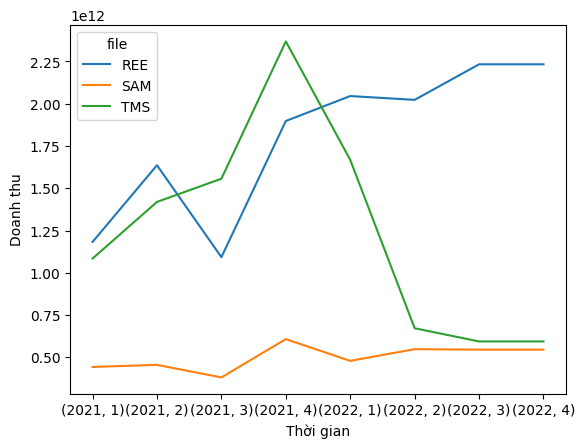

In [40]:
new.plot(xlabel='Thời gian',ylabel='Doanh thu')

- Tuy là những doanh nghiệp lên sàn sớm nhất nhưng tính hình doanh thu vẫn rất biến động 

## Phần 2: Mô Hình hoá Dữ liệu

### A. Mô hình hóa dữ liệu và đánh giá mô hình


In [53]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import plotly.express as px

#### 1. Mô hình dự đoán doanh thu thông qua giá vốn bán hàng. Sử dụng mô hình LinearRegression

In [54]:
df

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
0,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,1,A32
1,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,2,A32
2,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,3,A32
3,5.281309e+11,1.139765e+11,2.770250e+08,0.0,0.0,0.0,1.922260e+11,2.897457e+11,0.0,2.380572e+11,2.897457e+11,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2021,4,A32
4,5.281309e+11,1.139765e+11,2.770250e+08,0.0,0.0,0.0,1.922260e+11,2.897457e+11,0.0,2.380572e+11,2.897457e+11,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2022,1,A32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12088,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2021,4,YTC
12089,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,1,YTC
12090,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,2,YTC
12091,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,3,YTC


Lấy ra các cột 'netRevenue' , 'costPrice' , 'year' , 'quarter' , 'file' 

In [55]:
df_test = df[['netRevenue','costPrice','year','quarter','file']]

Ở đây ta sẽ lấy ra các dòng thuộc quý 4 năm 2022 để làm 1 dataframe dùng để test xem đường hồi quy có fit không

In [56]:
mask = (df_test['quarter'] == 4) & (df_test['year'] == 2022)
df_test_2 = df_test[mask]
df_test_2

,netRevenue,costPrice,year,quarter,file
7,0.000000e+00,0.000000e+00,2022,4,A32
15,3.280335e+12,2.972146e+12,2022,4,AAA
23,4.636050e+10,4.120229e+10,2022,4,AAM
38,1.183720e+11,1.077565e+11,2022,4,AAT
60,3.519471e+11,3.288836e+11,2022,4,ABC
...,...,...,...,...,...
12053,1.702518e+10,6.922496e+09,2022,4,XMP
12068,1.188447e+11,1.063045e+11,2022,4,YBC
12076,8.244484e+10,5.596804e+10,2022,4,YBM
12084,7.080504e+10,5.017056e+10,2022,4,YEG


Còn đây là dataframe dùng để trainning

In [57]:
mask = (df_test['quarter'] != 4) | (df_test['year'] != 2022)
df_test_1 = df_test[mask]
df_test_1

,netRevenue,costPrice,year,quarter,file
0,0.0,0.0,2021,1,A32
1,0.0,0.0,2021,2,A32
2,0.0,0.0,2021,3,A32
3,0.0,0.0,2021,4,A32
4,0.0,0.0,2022,1,A32
...,...,...,...,...,...
12087,0.0,0.0,2021,3,YTC
12088,0.0,0.0,2021,4,YTC
12089,0.0,0.0,2022,1,YTC
12090,0.0,0.0,2022,2,YTC


Tính hệ số tương quan

In [58]:
df_test_1[['netRevenue','costPrice']].corr()

,netRevenue,costPrice
netRevenue,1.000000,0.986717
costPrice,0.986717,1.000000


Lưu hai cột netRevenue và costPrice vào 2 biến độc lập

In [59]:
netRevenue = pd.DataFrame(df_test_1['netRevenue'])
costPrice = pd.DataFrame(df_test_1['costPrice'])

Tạo model

In [60]:
lm = linear_model.LinearRegression()
model = lm.fit(costPrice.values ,netRevenue.values)

Hệ số dự đoán của model

In [61]:
model.coef_

array([[1.14989708]])

Hệ số chặn y

In [62]:
model.intercept_

array([2.55525123e+10])

     ---------------------------------------- 15.3/15.3 MB 7.0 MB/s eta 0:00:00


Hệ số xác định của dự đoán.

In [63]:
model.score(costPrice.values,netRevenue.values)

0.9736099002059826

Lưu hai cột netRevenue và costPrice của df_test_2 vào 2 biến độc lập

In [64]:
netRevenue_test = pd.DataFrame(df_test_2['netRevenue'])
costPrice_test = pd.DataFrame(df_test_2['costPrice'])

#### Vẽ đồ thị tương quan giữa 2 biến netRevenue và costPrice:
- Các chấm màu xanh thể hiện sự tương quan giữa costPrice và netRevenue trong các quý 1,2,3,4 của năm 2021 và 1,2,3 của năm 2022
- Đường màu đỏ là đường hồi quy tuyến tính dựa trên tập dữ liệu df_test_1
- Các chấm màu đen thể hiện sự tương quan giữa costPrice và netRevenue trong quý 4 năm 2022

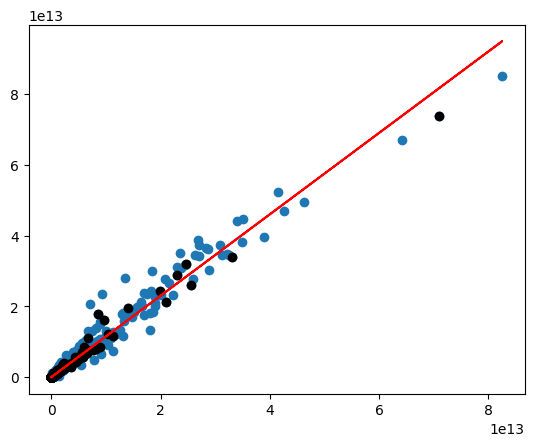

In [65]:
plt.scatter(costPrice,netRevenue)
plt.plot(costPrice , model.predict(costPrice.values), color='red')
plt.scatter(costPrice_test,netRevenue_test, color='black')

**Nhận xét:**
- Đường hồi quy là dự đoán doanh thu nếu tăng giá vốn hàng bán lên.
- Ta có thể thấy đường hồi quy khá fit với các điểm trên đồ thị. Bằng chứng là các điểm hầu như nằm rất gần hoặc năm trên đường hồi quy.
- Có thể thấy đường hồi quy cho ra một kết quả dự đoán khá chính xác, các chấm đen cũng năm rất gần đường hồi quy (sai lệch rất thấp).
- Tuy nhiên, doanh thuthật sự vẫn có trend tăng, nhưng thực tế là khi tăng giá vốn hàng bán, người dùng sẽ khó tiếp cận sản phẩm hơn, nên do đó doanh thu bán hàng của những mặt hàng bán tầm giá vốn đấy doanh thu ít hơn hẳn.


#

So sánh với LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, MLPClassifier, BaggingClassifier, SVC

In [66]:

kneighbor = KNeighborsRegressor().fit(costPrice.values, netRevenue.values)
decision = DecisionTreeRegressor().fit(costPrice.values, netRevenue.values)
neural = MLPRegressor().fit(costPrice.values, netRevenue.values)
bagging = BaggingRegressor().fit(costPrice.values, netRevenue.values)
svc = SVR().fit(costPrice.values, netRevenue.values)
gradient = SGDRegressor(loss='squared_error', max_iter=10).fit(costPrice.values, netRevenue.values)


c:\Users\Tin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Tin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_bagging.py:510: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Tin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Tin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py

In [67]:
linear_acc = model.score(costPrice.values, netRevenue.values)
kneighbor_acc = kneighbor.score(costPrice.values, netRevenue.values)
decision_acc = decision.score(costPrice.values, netRevenue.values)
neural_acc = neural.score(costPrice.values, netRevenue.values)
bagging_acc = bagging.score(costPrice.values, netRevenue.values)
svc_acc = svc.score(costPrice.values, netRevenue.values)
gradient_acc = gradient.score(costPrice.values, netRevenue.values)

In [68]:
fig = px.bar(
    x=['Linear','KNeighbor', 'Decision Tree', 'Neural Network', 'Bagging', 'SVC', 'Gradient'],
    y=[linear_acc,kneighbor_acc, decision_acc, neural_acc, bagging_acc, svc_acc, gradient_acc],
    color=['Linear','KNeighbor', 'Decision Tree', 'Neural Network', 'Bagging', 'SVC', 'Gradient'],
    labels={'x': 'Model', 'y': 'Accuracy'},
    title='Model Accuracy Comparison'
)

In [69]:
fig.show()

### Mô hình với prophet

In [70]:
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly

In [71]:
df_test_1

,netRevenue,costPrice,year,quarter,file
0,0.0,0.0,2021,1,A32
1,0.0,0.0,2021,2,A32
2,0.0,0.0,2021,3,A32
3,0.0,0.0,2021,4,A32
4,0.0,0.0,2022,1,A32
...,...,...,...,...,...
12087,0.0,0.0,2021,3,YTC
12088,0.0,0.0,2021,4,YTC
12089,0.0,0.0,2022,1,YTC
12090,0.0,0.0,2022,2,YTC


In [75]:
def calc_date_time(row):
    month = row['quarter'] * 3
    year = row['year']
    return f"30/{month}/{year}"

In [76]:
df_new = df_test_1.copy()
df_new['date'] = df_new.apply(calc_date_time,axis=1)

In [79]:
df_train = df_new[['netRevenue','date']]
df_train

,netRevenue,date
0,0.0,30/3/2021
1,0.0,30/6/2021
2,0.0,30/9/2021
3,0.0,30/12/2021
4,0.0,30/3/2022
...,...,...
12087,0.0,30/9/2021
12088,0.0,30/12/2021
12089,0.0,30/3/2022
12090,0.0,30/6/2022


In [80]:
df_train = df_train.rename(columns={'netRevenue':'y','date':'ds'})
df_train

,y,ds
0,0.0,30/3/2021
1,0.0,30/6/2021
2,0.0,30/9/2021
3,0.0,30/12/2021
4,0.0,30/3/2022
...,...,...
12087,0.0,30/9/2021
12088,0.0,30/12/2021
12089,0.0,30/3/2022
12090,0.0,30/6/2022


In [81]:
m = Prophet()
m.fit(df_train)

c:\Users\Tin\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\forecaster.py:1117: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

c:\Users\Tin\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\forecaster.py:270: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

In [84]:
plot_plotly(m,forecast)